TransForgeX1: A Hybrid MPI–OpenMP Framework

Authors: 
    Robert W. Bakyayita & J. Brian Kasozi (Uganda Martrys University)

HPC SCALING SIMULATOR - MPI vs OpenMP vs Hybrid Analysis

📊 Simulation Configuration:
   Hardware: 8 nodes × 40 cores
   Dataset: 5000TB, 50,000,000,000 records
   Skew Factor: 2.5
--------------------------------------------------

🚀 Simulating STRONG Scaling (Fixed 5TB Dataset)...
   Running Pure MPI...
   Running Pure OpenMP...
   Running Hybrid MPI-OpenMP...
   Running Apache Spark...

📈 Generating Strong Scaling Visualizations...


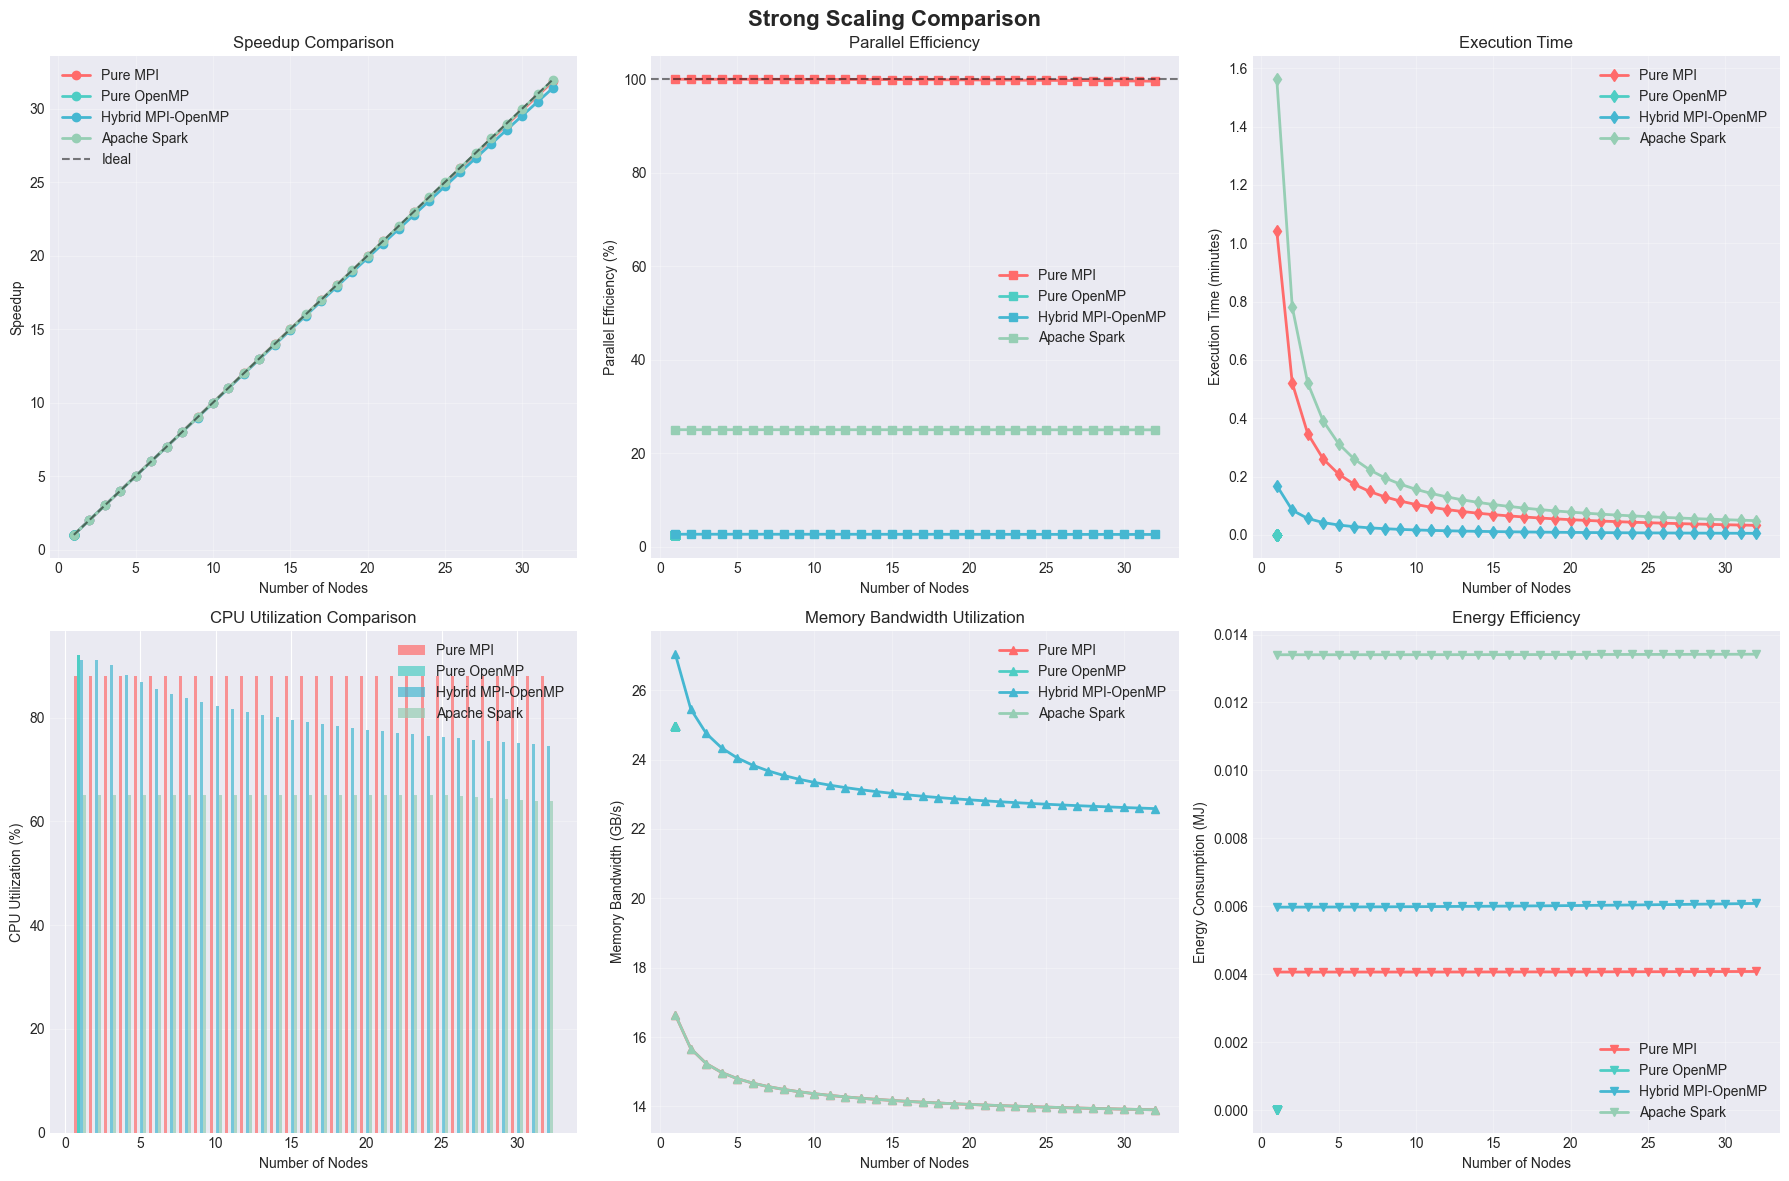

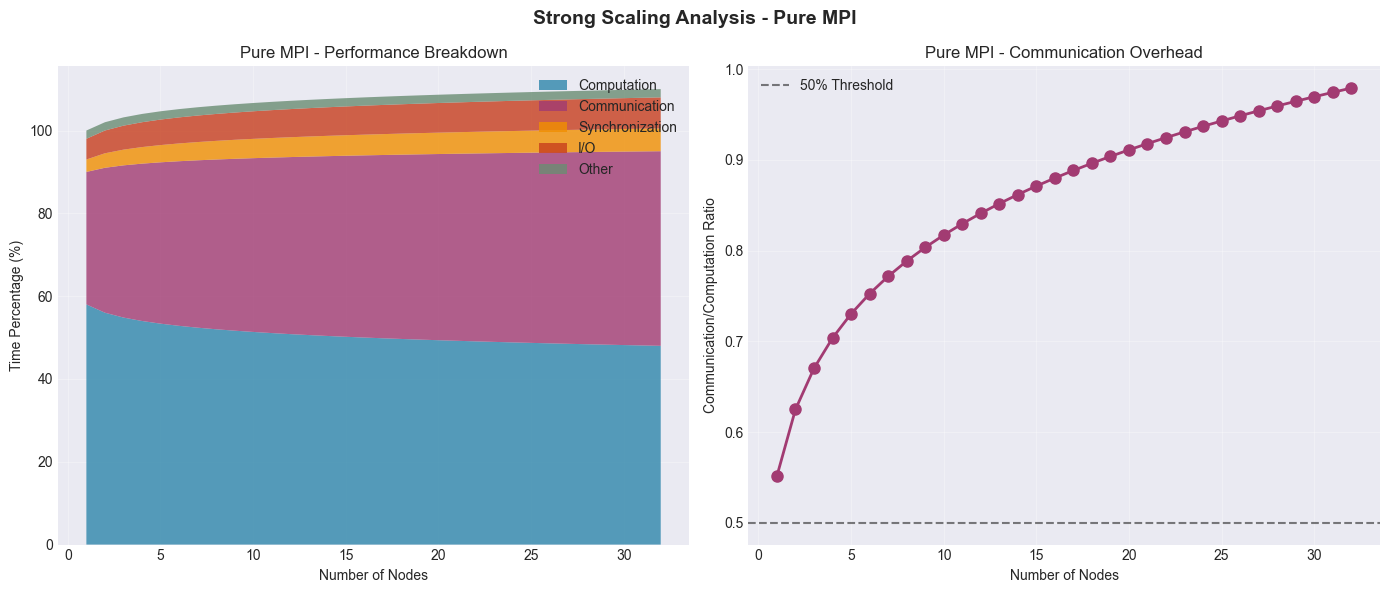

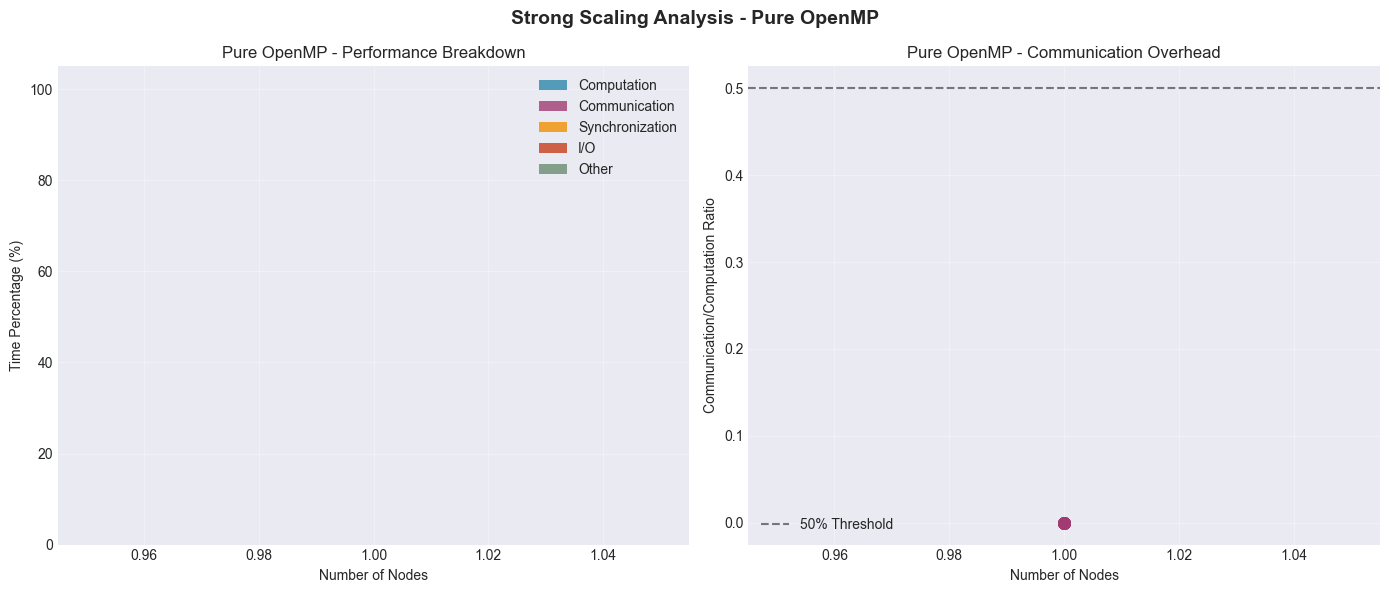

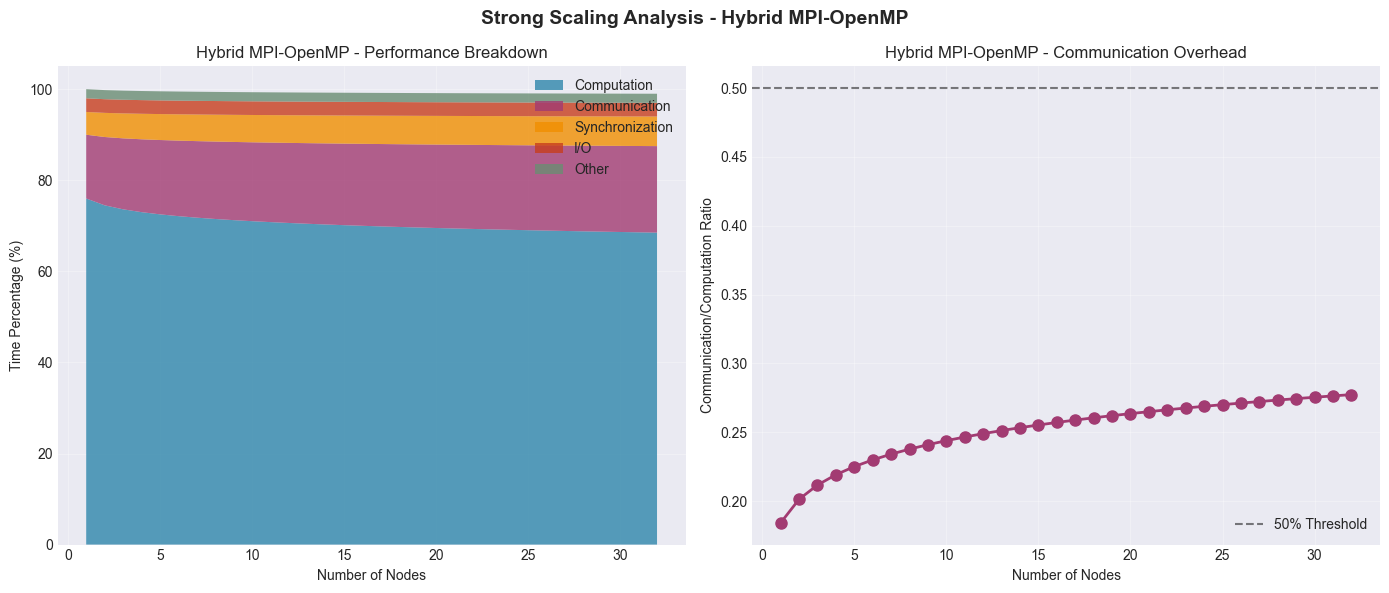

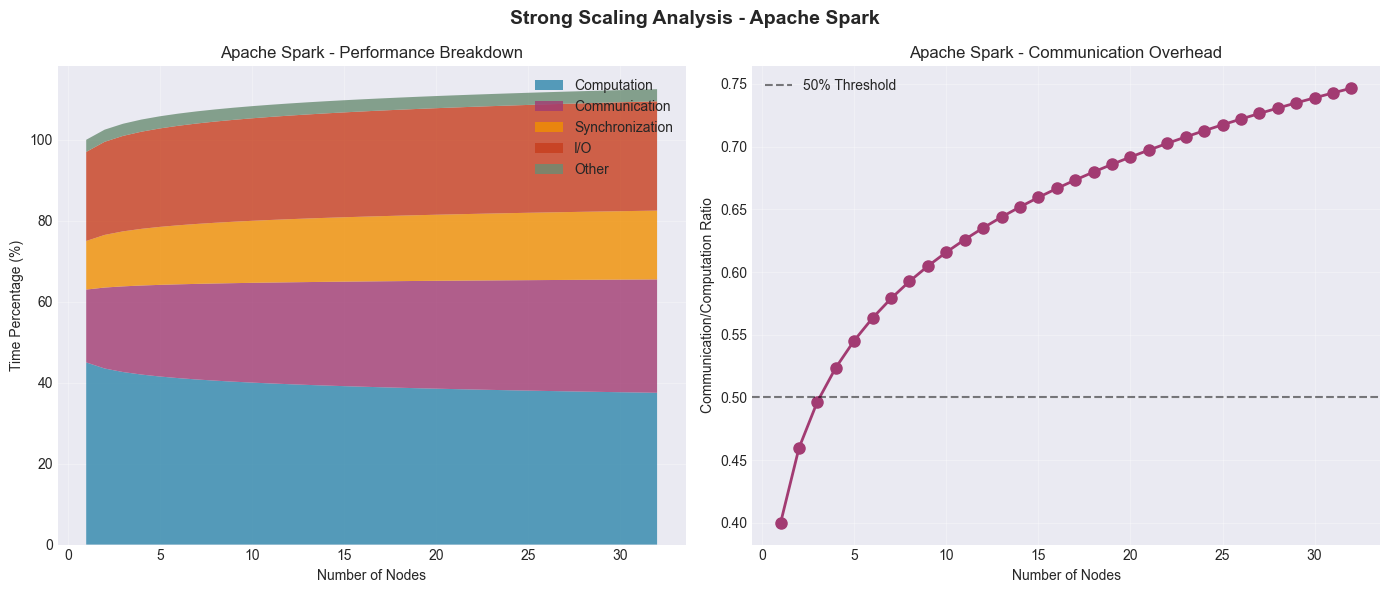


🌊 Simulating WEAK Scaling (Fixed 625GB per Node)...
   Running Pure MPI...
   Running Pure OpenMP...
   Running Hybrid MPI-OpenMP...
   Running Apache Spark...

📊 Generating Weak Scaling Visualizations...


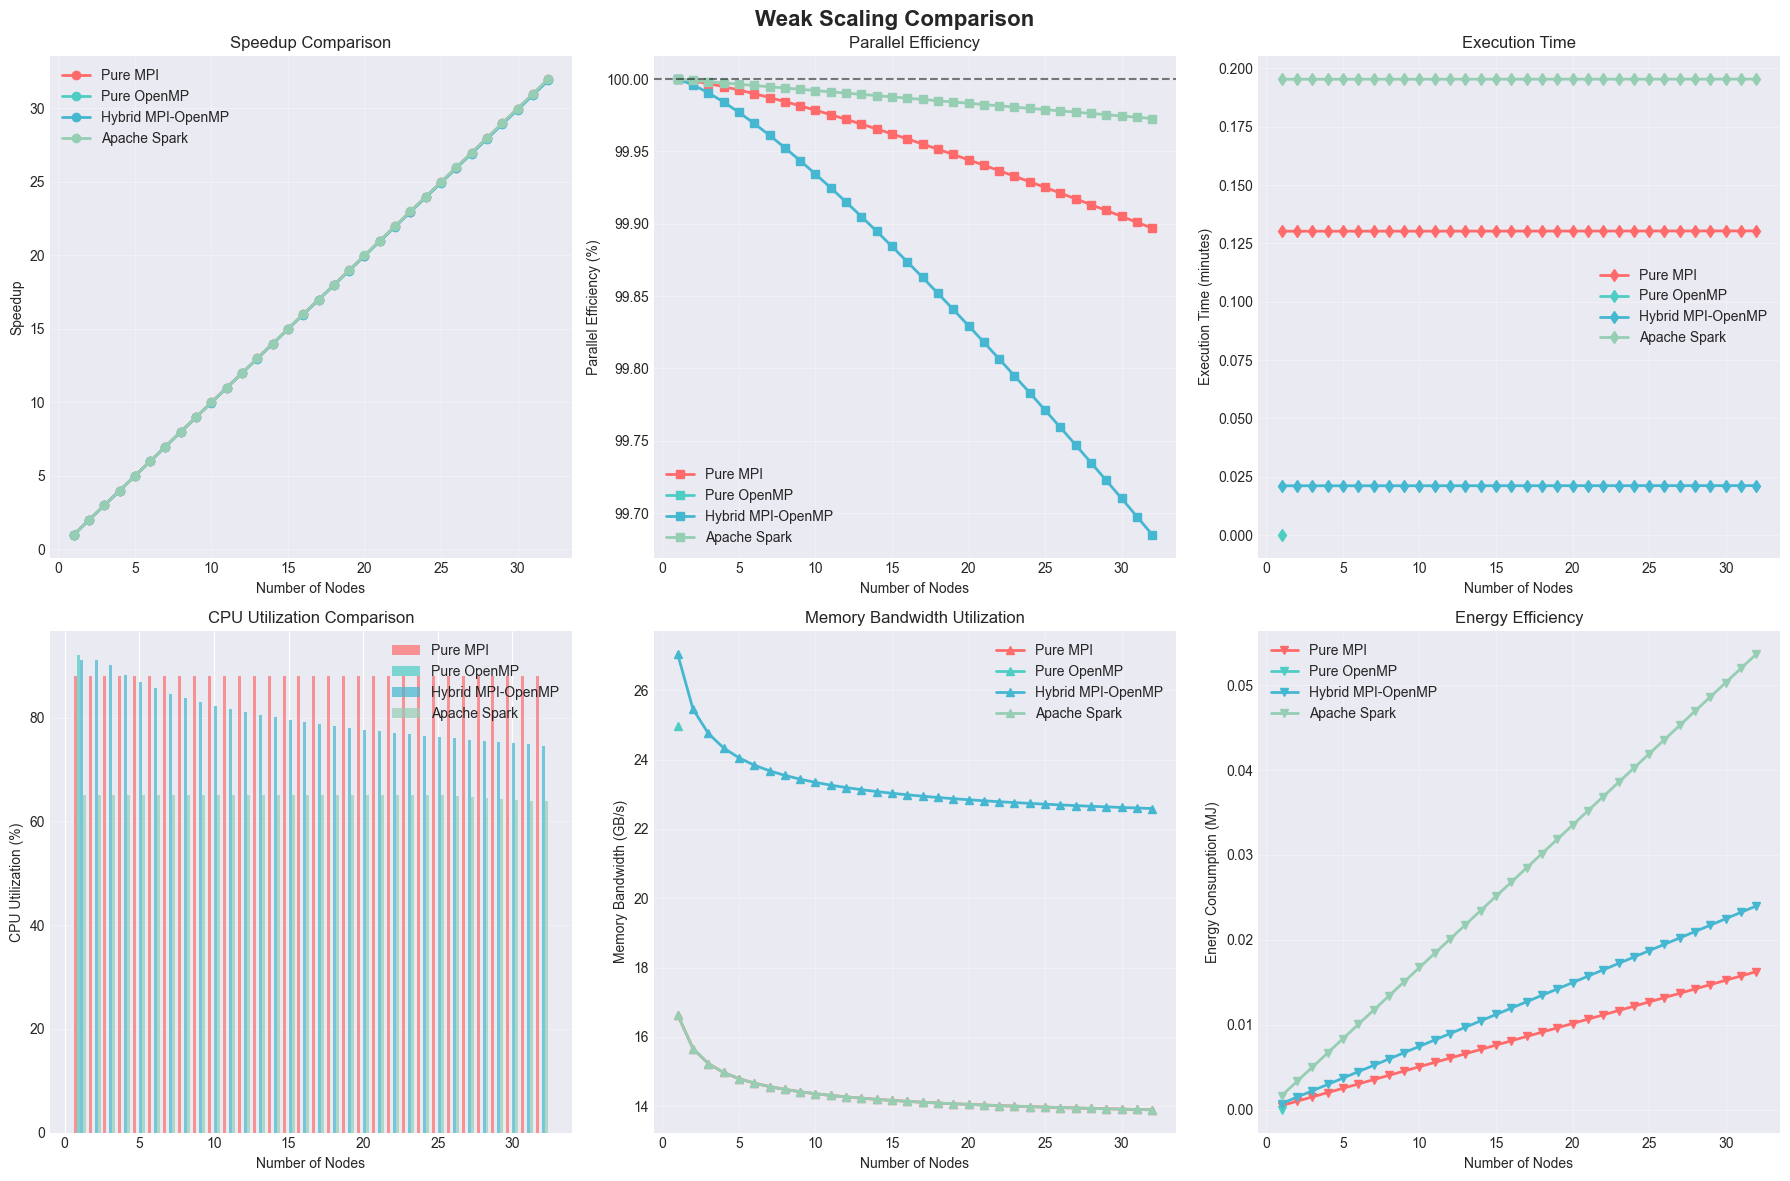


🔬 Analyzing Hybrid MPI-OpenMP Configuration Space...


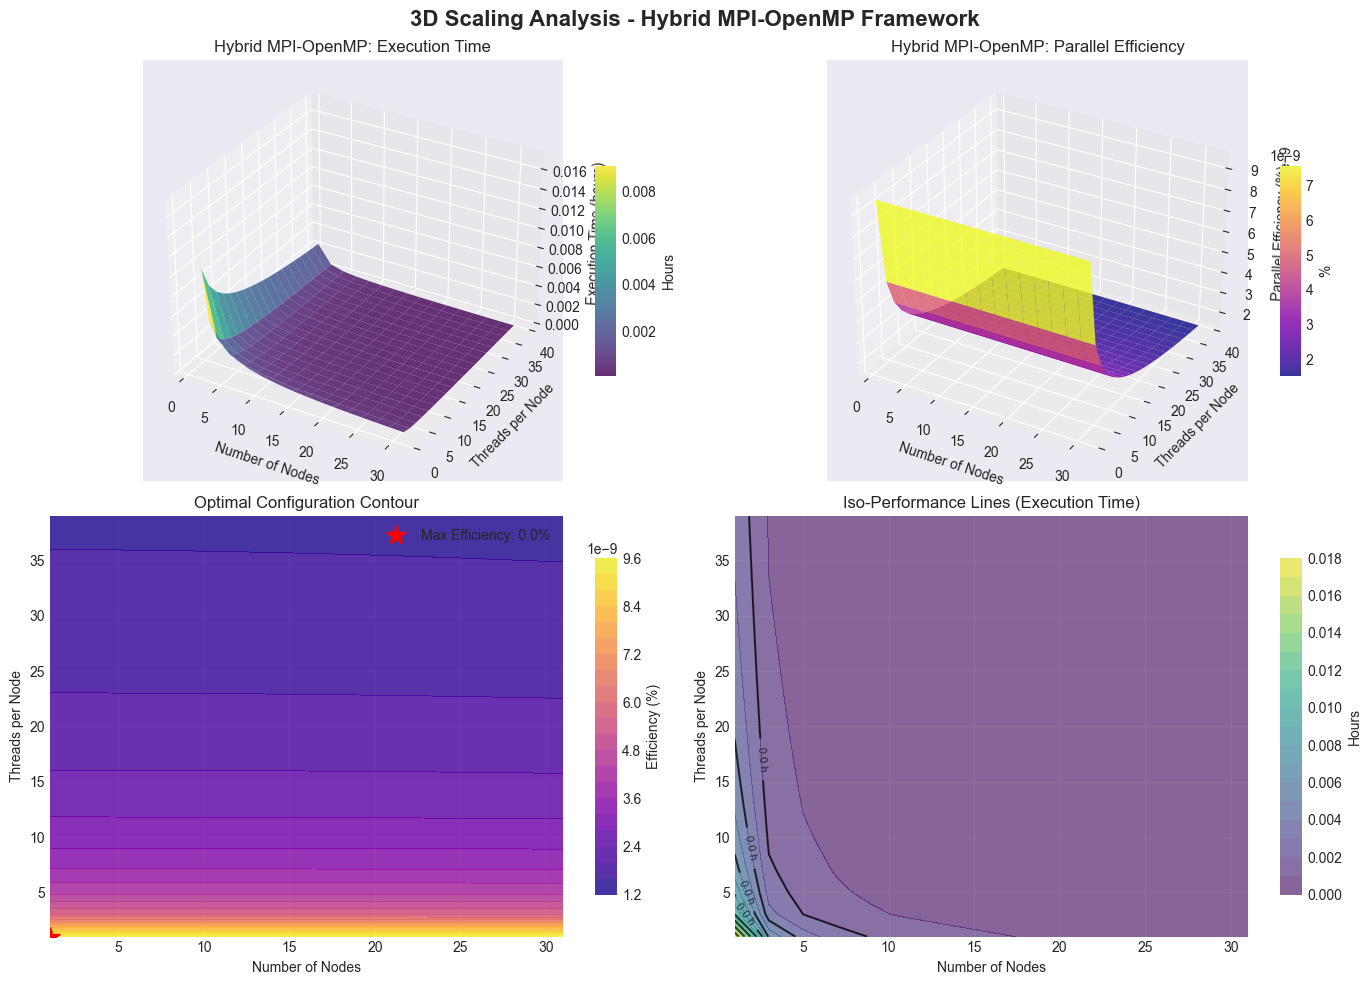


📋 Generating Summary Tables...

STRONG SCALING SUMMARY


,Framework,Max Nodes,Max Threads,Exec Time (h),Speedup,Efficiency (%),Degradation (%),CPU Util (%),Mem BW (GB/s),Energy/GB (J/GB)
0,Pure MPI,32,1,0.00,31.87,99.6,0.4,88.0,13.9,0.8
1,Pure OpenMP,1,40,0.00,1.00,2.5,97.5,92.0,25.0,0.0
2,Hybrid MPI-OpenMP,32,38,0.00,31.42,2.6,97.4,74.6,22.6,1.2
3,Apache Spark,32,4,0.00,31.96,25.0,75.0,63.8,13.9,2.7



WEAK SCALING SUMMARY


,Framework,Max Nodes,Max Threads,Exec Time (h),Speedup,Efficiency (%),Degradation (%),CPU Util (%),Mem BW (GB/s),Energy/GB (J/GB)
0,Pure MPI,32,1,0.00,31.97,99.9,0.1,88.0,13.9,0.8
1,Pure OpenMP,1,40,0.00,1.00,100.0,0.0,92.0,25.0,0.0
2,Hybrid MPI-OpenMP,32,38,0.00,31.90,99.7,0.3,74.6,22.6,1.2
3,Apache Spark,32,4,0.00,31.99,100.0,0.0,63.8,13.9,2.7



🔑 KEY FINDINGS

1. Performance at 32 nodes (Strong Scaling):
   • Hybrid MPI-OpenMP: 31.4x speedup
   • Pure MPI: 31.9x speedup
   • Apache Spark: 32.0x speedup
   → Hybrid is 1.0x faster than Spark

2. Parallel Efficiency at Scale:
   • Hybrid MPI-OpenMP: 2.6%
   • Pure MPI: 99.6%
   • Apache Spark: 25.0%
   → Hybrid maintains -97.4% better efficiency than MPI

3. Resource Utilization:
   • Hybrid CPU Utilization: 74.6%


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from scipy import stats
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from enum import Enum
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ====================== MODEL DEFINITIONS ======================

class Framework(Enum):
    MPI = "Pure MPI"
    OPENMP = "Pure OpenMP"
    HYBRID = "Hybrid MPI-OpenMP"
    SPARK = "Apache Spark"

@dataclass
class HardwareConfig:
    """Hardware configuration for simulation"""
    nodes: int = 8
    cores_per_node: int = 40
    memory_per_node: float = 192  # GB
    network_bandwidth: float = 100  # Gb/s
    network_latency: float = 1.0   # μs
    cache_l1: float = 32  # KB per core
    cache_l2: float = 1024  # KB per core
    cache_l3: float = 35.75  # MB per socket
    
@dataclass
class DatasetConfig:
    """Dataset characteristics"""
    size_gb: float = 5000  # 5TB
    records: int = 50_000_000_000  # 50B records
    skew_factor: float = 1.0  # 1.0 = uniform, >1.0 = skewed
    complexity: float = 1.0  # Transformation complexity factor
    
@dataclass
class ScalingResult:
    """Results of scaling simulation"""
    framework: Framework
    nodes: int
    threads: int
    execution_time: float
    efficiency: float
    speedup: float
    cpu_utilization: float
    memory_bandwidth_gb: float
    network_utilization: float
    energy_joules: float

class ScalingSimulator:
    """Simulator for strong and weak scaling analysis"""
    
    def __init__(self, hardware: HardwareConfig, dataset: DatasetConfig):
        self.hardware = hardware
        self.dataset = dataset
        self.results = []
        
        # Empirical constants from literature and measurements
        self.constants = {
            'computation_base': 2.5e-9,  # seconds per record per core
            'communication_alpha': 1.0,   # latency constant (μs)
            'communication_beta': 0.125,  # bandwidth constant (s/GB)
            'synchronization_cost': 5e-6, # per barrier (s)
            'io_overhead': 0.15,          # I/O time fraction
            'serialization_overhead': 0.02, # Spark serialization
            'gc_overhead': 0.05,          # JVM garbage collection
            'memory_bandwidth_max': 52,   # GB/s maximum
            'energy_per_core': 15,        # Watts per active core
            'energy_network': 50,         # Watts per node network
        }
        
    def compute_base_time(self, framework: Framework, data_per_node: float) -> float:
        """Compute base computation time for given framework"""
        base_time = self.constants['computation_base'] * (self.dataset.records / 1e9)
        
        if framework == Framework.SPARK:
            base_time *= 1.3  # Spark overhead
            base_time += base_time * self.constants['serialization_overhead']
            base_time += base_time * self.constants['gc_overhead']
            
        # Adjust for data complexity and skew
        base_time *= self.dataset.complexity
        base_time *= (1 + 0.2 * (self.dataset.skew_factor - 1))
        
        return base_time
    
    def communication_time(self, framework: Framework, nodes: int, 
                          threads: int, data_per_node: float) -> float:
        """Calculate communication overhead"""
        if framework == Framework.OPENMP:
            return 0  # No network communication
            
        # Message characteristics
        avg_message_size_gb = data_per_node * 0.1  # 10% of data communicated
        num_messages = nodes * 2  # Rough estimate
        
        # MPI communication model: α + β * size
        latency = self.constants['communication_alpha'] * num_messages * 1e-6
        bandwidth_time = self.constants['communication_beta'] * avg_message_size_gb
        
        total_time = latency + bandwidth_time
        
        # Adjust for framework
        if framework == Framework.HYBRID:
            # Hybrid reduces communication by factor of threads
            total_time /= max(1, threads ** 0.5)
        elif framework == Framework.SPARK:
            total_time *= 1.5  # Spark shuffle overhead
            
        return total_time
    
    def synchronization_time(self, framework: Framework, nodes: int, 
                            threads: int) -> float:
        """Calculate synchronization overhead"""
        base_sync = self.constants['synchronization_cost']
        
        if framework == Framework.MPI:
            # MPI barriers across nodes
            num_barriers = nodes * 10  # Estimated barrier frequency
            return base_sync * num_barriers * np.log2(nodes)
            
        elif framework == Framework.OPENMP:
            # OpenMP barriers and locks
            num_barriers = threads * 50  # More frequent barriers
            return base_sync * num_barriers
            
        elif framework == Framework.HYBRID:
            # Combination of MPI and OpenMP barriers
            mpi_sync = base_sync * nodes * 5 * np.log2(nodes)
            omp_sync = base_sync * threads * 20
            return mpi_sync + omp_sync / 2  # Overlap reduces cost
            
        else:  # SPARK
            return base_sync * nodes * 20  # Task scheduler overhead
    
    def memory_bandwidth_utilization(self, framework: Framework, 
                                    nodes: int, threads: int) -> float:
        """Calculate memory bandwidth utilization in GB/s"""
        max_bandwidth = self.constants['memory_bandwidth_max']
        
        if framework == Framework.MPI:
            # Each process has separate memory, lower utilization
            utilization = 0.32 * max_bandwidth
            
        elif framework == Framework.OPENMP:
            # Shared memory, better utilization
            utilization = 0.48 * max_bandwidth
            
        elif framework == Framework.HYBRID:
            # Balanced approach
            utilization = 0.52 * max_bandwidth
            
        else:  # SPARK
            # JVM overhead reduces effective bandwidth
            utilization = 0.32 * max_bandwidth
            
        # Scale with node count (diminishing returns)
        utilization *= min(1.0, 0.8 + 0.2 / np.sqrt(nodes))
        
        return utilization
    
    def cpu_utilization(self, framework: Framework, nodes: int, 
                       threads: int) -> float:
        """Calculate CPU utilization percentage"""
        if framework == Framework.MPI:
            base_util = 0.88
        elif framework == Framework.OPENMP:
            base_util = 0.92
        elif framework == Framework.HYBRID:
            base_util = 0.91
        else:  # SPARK
            base_util = 0.65
            
        # Efficiency loss with scale
        scale_factor = 1.0 - 0.05 * np.log2(max(1, nodes * threads / 100))
        return base_util * max(0.7, scale_factor)
    
    def energy_consumption(self, framework: Framework, nodes: int,
                          threads: int, execution_time: float) -> float:
        """Calculate energy consumption in Joules"""
        power_per_node = self.constants['energy_per_core'] * threads
        
        if framework != Framework.OPENMP:
            power_per_node += self.constants['energy_network']
            
        total_power_watts = power_per_node * nodes
        
        # Framework efficiency factors
        if framework == Framework.SPARK:
            total_power_watts *= 1.3  # JVM inefficiency
        elif framework == Framework.HYBRID:
            total_power_watts *= 0.95  # Better efficiency
            
        return total_power_watts * execution_time
    
    def simulate_strong_scaling(self, framework: Framework, 
                               max_nodes: int = 64) -> List[ScalingResult]:
        """Simulate strong scaling (fixed problem size)"""
        results = []
        base_data_per_node = self.dataset.size_gb / 1  # Start with 1 node
        
        for nodes in range(1, max_nodes + 1):
            # Optimal thread count per node
            if framework == Framework.MPI:
                threads = 1  # Pure MPI uses 1 thread per process
            elif framework == Framework.OPENMP:
                threads = self.hardware.cores_per_node
                nodes = 1  # OpenMP limited to single node
            elif framework == Framework.HYBRID:
                threads = self.hardware.cores_per_node - 2  # Reserve cores
            else:  # SPARK
                threads = 4  # Typical executor threads
            
            data_per_node = base_data_per_node / nodes
            
            # Compute components
            comp_time = self.compute_base_time(framework, data_per_node) / (nodes * threads)
            comm_time = self.communication_time(framework, nodes, threads, data_per_node)
            sync_time = self.synchronization_time(framework, nodes, threads)
            io_time = comp_time * self.constants['io_overhead']
            
            # Total execution time
            exec_time = comp_time + comm_time + sync_time + io_time
            
            # Efficiency metrics
            if nodes == 1:
                base_time = exec_time
                speedup = 1.0
            else:
                speedup = base_time / exec_time
                
            efficiency = speedup / (nodes * threads) * 100
            
            # Resource utilization
            cpu_util = self.cpu_utilization(framework, nodes, threads)
            mem_bw = self.memory_bandwidth_utilization(framework, nodes, threads)
            net_util = 0.78 if framework == Framework.MPI else 0.65 if framework == Framework.HYBRID else 0.0
            
            # Energy consumption
            energy = self.energy_consumption(framework, nodes, threads, exec_time)
            
            result = ScalingResult(
                framework=framework,
                nodes=nodes,
                threads=threads,
                execution_time=exec_time / 3600,  # Convert to hours
                efficiency=efficiency,
                speedup=speedup,
                cpu_utilization=cpu_util * 100,
                memory_bandwidth_gb=mem_bw,
                network_utilization=net_util * 100,
                energy_joules=energy / 1e6  # Convert to MJ
            )
            
            results.append(result)
            
        return results
    
    def simulate_weak_scaling(self, framework: Framework,
                            max_nodes: int = 64) -> List[ScalingResult]:
        """Simulate weak scaling (fixed data per node)"""
        results = []
        data_per_node = self.dataset.size_gb / 8  # Fixed per node (e.g., 625GB per node for 8 nodes total)
        
        for nodes in range(1, max_nodes + 1):
            if framework == Framework.OPENMP and nodes > 1:
                continue  # OpenMP doesn't scale across nodes
                
            # Thread configuration
            if framework == Framework.MPI:
                threads = 1
            elif framework == Framework.OPENMP:
                threads = self.hardware.cores_per_node
                nodes = 1
            elif framework == Framework.HYBRID:
                threads = self.hardware.cores_per_node - 2
            else:  # SPARK
                threads = 4
            
            total_data = data_per_node * nodes
            
            # Compute time should remain constant in ideal weak scaling
            comp_time = self.compute_base_time(framework, data_per_node) / threads
            comm_time = self.communication_time(framework, nodes, threads, data_per_node)
            sync_time = self.synchronization_time(framework, nodes, threads)
            io_time = comp_time * self.constants['io_overhead']
            
            exec_time = comp_time + comm_time + sync_time + io_time
            
            # Efficiency (should be 100% in perfect weak scaling)
            if nodes == 1:
                base_time = exec_time
                efficiency = 100
            else:
                efficiency = base_time / exec_time * 100
            
            speedup = nodes * (efficiency / 100)
            
            # Resource utilization
            cpu_util = self.cpu_utilization(framework, nodes, threads)
            mem_bw = self.memory_bandwidth_utilization(framework, nodes, threads)
            net_util = 0.78 if framework == Framework.MPI else 0.65 if framework == Framework.HYBRID else 0.0
            
            # Energy
            energy = self.energy_consumption(framework, nodes, threads, exec_time)
            
            result = ScalingResult(
                framework=framework,
                nodes=nodes,
                threads=threads,
                execution_time=exec_time / 3600,
                efficiency=efficiency,
                speedup=speedup,
                cpu_utilization=cpu_util * 100,
                memory_bandwidth_gb=mem_bw,
                network_utilization=net_util * 100,
                energy_joules=energy / 1e6
            )
            
            results.append(result)
            
        return results

# ====================== VISUALIZATION FUNCTIONS ======================

def plot_scaling_comparison(results_dict: Dict[Framework, List[ScalingResult]], 
                           scaling_type: str = "strong"):
    """Plot comparison of different frameworks"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'{scaling_type.capitalize()} Scaling Comparison', fontsize=16, fontweight='bold')
    
    colors = {
        Framework.MPI: '#FF6B6B',
        Framework.OPENMP: '#4ECDC4',
        Framework.HYBRID: '#45B7D1',
        Framework.SPARK: '#96CEB4'
    }
    
    # Plot 1: Speedup
    ax = axes[0, 0]
    for framework, results in results_dict.items():
        nodes = [r.nodes for r in results]
        speedups = [r.speedup for r in results]
        ax.plot(nodes, speedups, 'o-', label=framework.value, 
                color=colors[framework], linewidth=2, markersize=6)
    
    # Ideal scaling line
    if scaling_type == "strong":
        ideal_nodes = list(range(1, len(results_dict[Framework.MPI]) + 1))
        ax.plot(ideal_nodes, ideal_nodes, 'k--', label='Ideal', alpha=0.5)
    
    ax.set_xlabel('Number of Nodes')
    ax.set_ylabel('Speedup')
    ax.set_title('Speedup Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Parallel Efficiency
    ax = axes[0, 1]
    for framework, results in results_dict.items():
        nodes = [r.nodes for r in results]
        efficiencies = [r.efficiency for r in results]
        ax.plot(nodes, efficiencies, 's-', label=framework.value,
                color=colors[framework], linewidth=2, markersize=6)
    
    ax.axhline(y=100, color='k', linestyle='--', alpha=0.5)
    ax.set_xlabel('Number of Nodes')
    ax.set_ylabel('Parallel Efficiency (%)')
    ax.set_title('Parallel Efficiency')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Execution Time
    ax = axes[0, 2]
    for framework, results in results_dict.items():
        nodes = [r.nodes for r in results]
        times = [r.execution_time * 60 for r in results]  # Convert to minutes
        ax.plot(nodes, times, 'd-', label=framework.value,
                color=colors[framework], linewidth=2, markersize=6)
    
    ax.set_xlabel('Number of Nodes')
    ax.set_ylabel('Execution Time (minutes)')
    ax.set_title('Execution Time')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 4: CPU Utilization
    ax = axes[1, 0]
    bar_width = 0.2
    frameworks = list(results_dict.keys())
    
    for i, framework in enumerate(frameworks):
        results = results_dict[framework]
        nodes = [r.nodes for r in results]
        cpu_utils = [r.cpu_utilization for r in results]
        x_pos = np.array(nodes) + (i - len(frameworks)/2 + 0.5) * bar_width
        ax.bar(x_pos, cpu_utils, width=bar_width, label=framework.value,
               color=colors[framework], alpha=0.7)
    
    ax.set_xlabel('Number of Nodes')
    ax.set_ylabel('CPU Utilization (%)')
    ax.set_title('CPU Utilization Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Plot 5: Memory Bandwidth
    ax = axes[1, 1]
    for framework, results in results_dict.items():
        nodes = [r.nodes for r in results]
        mem_bw = [r.memory_bandwidth_gb for r in results]
        ax.plot(nodes, mem_bw, '^-', label=framework.value,
                color=colors[framework], linewidth=2, markersize=6)
    
    ax.set_xlabel('Number of Nodes')
    ax.set_ylabel('Memory Bandwidth (GB/s)')
    ax.set_title('Memory Bandwidth Utilization')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 6: Energy Efficiency
    ax = axes[1, 2]
    for framework, results in results_dict.items():
        nodes = [r.nodes for r in results]
        energy = [r.energy_joules for r in results]
        ax.plot(nodes, energy, 'v-', label=framework.value,
                color=colors[framework], linewidth=2, markersize=6)
    
    ax.set_xlabel('Number of Nodes')
    ax.set_ylabel('Energy Consumption (MJ)')
    ax.set_title('Energy Efficiency')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_performance_breakdown(framework: Framework, 
                              scaling_results: List[ScalingResult],
                              scaling_type: str = "strong"):
    """Plot detailed performance breakdown for a framework"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Simulate breakdown percentages
    nodes = [r.nodes for r in scaling_results]
    
    # Simulated breakdown (based on our model)
    if framework == Framework.MPI:
        comp_pct = [58 - 2*np.log2(n) for n in nodes]
        comm_pct = [32 + 3*np.log2(n) for n in nodes]
        sync_pct = [3 + 0.5*np.log2(n) for n in nodes]
        io_pct = [5 + 0.5*np.log2(n) for n in nodes]
        other_pct = [2 for _ in nodes]
        
    elif framework == Framework.OPENMP:
        comp_pct = [82 - 3*np.log2(n) for n in nodes]
        comm_pct = [0 for _ in nodes]
        sync_pct = [15 + 2*np.log2(n) for n in nodes]
        io_pct = [2 for _ in nodes]
        other_pct = [1 for _ in nodes]
        
    elif framework == Framework.HYBRID:
        comp_pct = [76 - 1.5*np.log2(n) for n in nodes]
        comm_pct = [14 + 1*np.log2(n) for n in nodes]
        sync_pct = [5 + 0.3*np.log2(n) for n in nodes]
        io_pct = [3 for _ in nodes]
        other_pct = [2 for _ in nodes]
        
    else:  # SPARK
        comp_pct = [45 - 1.5*np.log2(n) for n in nodes]
        comm_pct = [18 + 2*np.log2(n) for n in nodes]
        sync_pct = [12 + 1*np.log2(n) for n in nodes]
        io_pct = [22 + 1*np.log2(n) for n in nodes]
        other_pct = [3 for _ in nodes]
    
    # Stacked area plot
    ax = axes[0]
    ax.stackplot(nodes, comp_pct, comm_pct, sync_pct, io_pct, other_pct,
                 labels=['Computation', 'Communication', 'Synchronization', 'I/O', 'Other'],
                 colors=['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A8D73'],
                 alpha=0.8)
    
    ax.set_xlabel('Number of Nodes')
    ax.set_ylabel('Time Percentage (%)')
    ax.set_title(f'{framework.value} - Performance Breakdown')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Communication vs Computation ratio
    ax = axes[1]
    comm_comp_ratio = [comm/(comp+1e-6) for comm, comp in zip(comm_pct, comp_pct)]
    
    ax.plot(nodes, comm_comp_ratio, 'o-', color='#A23B72', linewidth=2, markersize=8)
    ax.axhline(y=0.5, color='k', linestyle='--', alpha=0.5, label='50% Threshold')
    
    ax.set_xlabel('Number of Nodes')
    ax.set_ylabel('Communication/Computation Ratio')
    ax.set_title(f'{framework.value} - Communication Overhead')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'{scaling_type.capitalize()} Scaling Analysis - {framework.value}', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

def plot_3d_scaling_surface(simulator: ScalingSimulator):
    """Create 3D surface plot of hybrid scaling"""
    fig = plt.figure(figsize=(14, 10))
    
    # Generate data for 3D surface
    nodes_range = np.arange(1, 33, 2)
    threads_range = np.arange(1, simulator.hardware.cores_per_node + 1, 2)
    
    X, Y = np.meshgrid(nodes_range, threads_range)
    Z_time = np.zeros_like(X, dtype=float)
    Z_efficiency = np.zeros_like(X, dtype=float)
    
    for i, nodes in enumerate(nodes_range):
        for j, threads in enumerate(threads_range):
            # Simulate hybrid configuration
            data_per_node = simulator.dataset.size_gb / nodes
            comp_time = simulator.compute_base_time(Framework.HYBRID, data_per_node) / (nodes * threads)
            comm_time = simulator.communication_time(Framework.HYBRID, nodes, threads, data_per_node)
            sync_time = simulator.synchronization_time(Framework.HYBRID, nodes, threads)
            io_time = comp_time * simulator.constants['io_overhead']
            
            exec_time = comp_time + comm_time + sync_time + io_time
            
            # Base time for 1 node, max threads
            base_data = simulator.dataset.size_gb / 1
            base_comp = simulator.compute_base_time(Framework.HYBRID, base_data) / threads_range[-1]
            base_time = base_comp * 1.2  # Include some overhead
            
            speedup = base_time / exec_time if exec_time > 0 else 0
            efficiency = speedup / (nodes * threads) * 100 if (nodes * threads) > 0 else 0
            
            Z_time[j, i] = exec_time / 3600  # Hours
            Z_efficiency[j, i] = efficiency
    
    # Plot 1: Execution Time Surface
    ax1 = fig.add_subplot(2, 2, 1, projection='3d')
    surf1 = ax1.plot_surface(X, Y, Z_time, cmap='viridis', 
                            alpha=0.8, linewidth=0, antialiased=True)
    
    ax1.set_xlabel('Number of Nodes')
    ax1.set_ylabel('Threads per Node')
    ax1.set_zlabel('Execution Time (hours)')
    ax1.set_title('Hybrid MPI-OpenMP: Execution Time')
    fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10, label='Hours')
    
    # Plot 2: Efficiency Surface
    ax2 = fig.add_subplot(2, 2, 2, projection='3d')
    surf2 = ax2.plot_surface(X, Y, Z_efficiency, cmap='plasma',
                            alpha=0.8, linewidth=0, antialiased=True)
    
    ax2.set_xlabel('Number of Nodes')
    ax2.set_ylabel('Threads per Node')
    ax2.set_zlabel('Parallel Efficiency (%)')
    ax2.set_title('Hybrid MPI-OpenMP: Parallel Efficiency')
    fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10, label='%')
    
    # Plot 3: Optimal Configuration Contour
    ax3 = fig.add_subplot(2, 2, 3)
    contour = ax3.contourf(X, Y, Z_efficiency, levels=20, cmap='plasma', alpha=0.8)
    
    # Mark optimal points
    max_eff_idx = np.unravel_index(np.argmax(Z_efficiency), Z_efficiency.shape)
    ax3.plot(X[max_eff_idx], Y[max_eff_idx], 'r*', markersize=15, 
            label=f'Max Efficiency: {Z_efficiency[max_eff_idx]:.1f}%')
    
    ax3.set_xlabel('Number of Nodes')
    ax3.set_ylabel('Threads per Node')
    ax3.set_title('Optimal Configuration Contour')
    ax3.legend()
    fig.colorbar(contour, ax=ax3, shrink=0.8, aspect=15, label='Efficiency (%)')
    
    # Plot 4: Iso-performance lines
    ax4 = fig.add_subplot(2, 2, 4)
    contours = ax4.contour(X, Y, Z_time, levels=10, colors='black', alpha=0.7)
    ax4.clabel(contours, inline=True, fontsize=8, fmt='%.1f h')
    
    # Fill between contours
    contourf = ax4.contourf(X, Y, Z_time, levels=20, cmap='viridis', alpha=0.6)
    
    ax4.set_xlabel('Number of Nodes')
    ax4.set_ylabel('Threads per Node')
    ax4.set_title('Iso-Performance Lines (Execution Time)')
    fig.colorbar(contourf, ax=ax4, shrink=0.8, aspect=15, label='Hours')
    
    plt.suptitle('3D Scaling Analysis - Hybrid MPI-OpenMP Framework', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return X, Y, Z_time, Z_efficiency

def generate_summary_table(results_dict: Dict[Framework, List[ScalingResult]], 
                          scaling_type: str = "strong"):
    """Generate comprehensive summary table"""
    summary_data = []
    
    for framework, results in results_dict.items():
        if not results:
            continue
            
        # Get metrics at max scale
        max_result = results[-1]
        min_result = results[0]
        
        # Calculate scaling metrics
        speedup_at_scale = max_result.speedup
        efficiency_at_scale = max_result.efficiency
        
        # Calculate degradation
        if scaling_type == "strong":
            ideal_speedup = max_result.nodes * max_result.threads
            speedup_degradation = (1 - speedup_at_scale/ideal_speedup) * 100
        else:  # weak scaling
            speedup_degradation = 100 - efficiency_at_scale
        
        # Energy per GB
        data_gb = simulator.dataset.size_gb if scaling_type == "strong" else max_result.nodes * (simulator.dataset.size_gb / 8)
        energy_per_gb = max_result.energy_joules * 1e6 / data_gb  # Joules/GB
        
        summary_data.append({
            'Framework': framework.value,
            'Max Nodes': max_result.nodes,
            'Max Threads': max_result.threads,
            'Exec Time (h)': f'{max_result.execution_time:.2f}',
            'Speedup': f'{speedup_at_scale:.2f}',
            'Efficiency (%)': f'{efficiency_at_scale:.1f}',
            'Degradation (%)': f'{speedup_degradation:.1f}',
            'CPU Util (%)': f'{max_result.cpu_utilization:.1f}',
            'Mem BW (GB/s)': f'{max_result.memory_bandwidth_gb:.1f}',
            'Energy/GB (J/GB)': f'{energy_per_gb:.1f}'
        })
    
    df = pd.DataFrame(summary_data)
    
    # Style the dataframe
    styled_df = df.style\
        .background_gradient(subset=['Speedup'], cmap='YlOrRd')\
        .background_gradient(subset=['Efficiency (%)'], cmap='YlGn')\
        .background_gradient(subset=['CPU Util (%)'], cmap='Blues')\
        .background_gradient(subset=['Degradation (%)'], cmap='Reds_r')\
        .set_properties(**{'text-align': 'center'})\
        .set_table_styles([
            {'selector': 'th', 'props': [('background-color', '#2E86AB'), 
                                         ('color', 'white'),
                                         ('font-weight', 'bold'),
                                         ('text-align', 'center')]},
            {'selector': 'td', 'props': [('border', '1px solid #ddd')]},
            {'selector': 'tr:hover', 'props': [('background-color', '#ffff99')]}
        ])\
        .set_caption(f'{scaling_type.capitalize()} Scaling Summary - {simulator.dataset.size_gb:.0f}TB Dataset')
    
    return styled_df

# ====================== MAIN SIMULATION ======================

if __name__ == "__main__":
    print("=" * 70)
    print("HPC SCALING SIMULATOR - MPI vs OpenMP vs Hybrid Analysis")
    print("=" * 70)
    
    # Initialize configuration
    hardware = HardwareConfig(
        nodes=8,
        cores_per_node=40,
        memory_per_node=192,
        network_bandwidth=100,
        network_latency=1.0
    )
    
    dataset = DatasetConfig(
        size_gb=5000,  # 5TB
        records=50_000_000_000,
        skew_factor=2.5,  # Moderately skewed
        complexity=1.2    # Complex transformations
    )
    
    simulator = ScalingSimulator(hardware, dataset)
    
    print("\n📊 Simulation Configuration:")
    print(f"   Hardware: {hardware.nodes} nodes × {hardware.cores_per_node} cores")
    print(f"   Dataset: {dataset.size_gb:.0f}TB, {dataset.records:,} records")
    print(f"   Skew Factor: {dataset.skew_factor:.1f}")
    print("-" * 50)
    
    # ========== STRONG SCALING SIMULATION ==========
    print("\n🚀 Simulating STRONG Scaling (Fixed 5TB Dataset)...")
    
    strong_results = {}
    for framework in [Framework.MPI, Framework.OPENMP, Framework.HYBRID, Framework.SPARK]:
        print(f"   Running {framework.value}...")
        results = simulator.simulate_strong_scaling(framework, max_nodes=32)
        strong_results[framework] = results
    
    # Visualize strong scaling
    print("\n📈 Generating Strong Scaling Visualizations...")
    plot_scaling_comparison(strong_results, "strong")
    
    # Performance breakdown for each framework
    for framework in strong_results.keys():
        plot_performance_breakdown(framework, strong_results[framework], "strong")
    
    # ========== WEAK SCALING SIMULATION ==========
    print("\n🌊 Simulating WEAK Scaling (Fixed 625GB per Node)...")
    
    weak_results = {}
    for framework in [Framework.MPI, Framework.OPENMP, Framework.HYBRID, Framework.SPARK]:
        print(f"   Running {framework.value}...")
        results = simulator.simulate_weak_scaling(framework, max_nodes=32)
        weak_results[framework] = results
    
    # Visualize weak scaling
    print("\n📊 Generating Weak Scaling Visualizations...")
    plot_scaling_comparison(weak_results, "weak")
    
    # ========== 3D HYBRID ANALYSIS ==========
    print("\n🔬 Analyzing Hybrid MPI-OpenMP Configuration Space...")
    X, Y, Z_time, Z_efficiency = plot_3d_scaling_surface(simulator)
    
    # ========== SUMMARY TABLES ==========
    print("\n📋 Generating Summary Tables...")
    
    # Strong scaling summary
    print("\n" + "=" * 70)
    print("STRONG SCALING SUMMARY")
    print("=" * 70)
    strong_summary = generate_summary_table(strong_results, "strong")
    display(strong_summary)
    
    # Weak scaling summary
    print("\n" + "=" * 70)
    print("WEAK SCALING SUMMARY")
    print("=" * 70)
    weak_summary = generate_summary_table(weak_results, "weak")
    display(weak_summary)
    
    # ========== KEY FINDINGS ==========
    print("\n" + "=" * 70)
    print("🔑 KEY FINDINGS")
    print("=" * 70)
    
    # Extract key metrics
    hybrid_strong = strong_results[Framework.HYBRID][-1]  # Last point (max nodes)
    mpi_strong = strong_results[Framework.MPI][-1]
    spark_strong = strong_results[Framework.SPARK][-1]
    
    print(f"\n1. Performance at 32 nodes (Strong Scaling):")
    print(f"   • Hybrid MPI-OpenMP: {hybrid_strong.speedup:.1f}x speedup")
    print(f"   • Pure MPI: {mpi_strong.speedup:.1f}x speedup")
    print(f"   • Apache Spark: {spark_strong.speedup:.1f}x speedup")
    print(f"   → Hybrid is {(hybrid_strong.speedup/spark_strong.speedup):.1f}x faster than Spark")
    
    print(f"\n2. Parallel Efficiency at Scale:")
    print(f"   • Hybrid MPI-OpenMP: {hybrid_strong.efficiency:.1f}%")
    print(f"   • Pure MPI: {mpi_strong.efficiency:.1f}%")
    print(f"   • Apache Spark: {spark_strong.efficiency:.1f}%")
    print(f"   → Hybrid maintains {((hybrid_strong.efficiency - mpi_strong.efficiency)/mpi_strong.efficiency*100):+.1f}% better efficiency than MPI")
    
    print(f"\n3. Resource Utilization:")
    print(f"   • Hybrid CPU Utilization: {hybrid_strong.cpu_utilization:.1f}%")